# Project Description - Tools classification and localization using ViT
**Introduction** <br>
This is a project of tools classification/localization. There are 6 different classes:
- Cutter
- Tongs
- Screws_box
- Screwdriver
- Drill_bit
- Allen_keys

**Outline** <br>
This project will have the presentation outlined as follows,
1. Dataset visualization
2. Model training and validation
3. Model testing
4. Results evaluation
5. Model prediction

## Imports

In [ ]:
# Import necessary libraries

import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import glob
import random
from matplotlib.patches import Rectangle
from matplotlib import pyplot
from lxml import etree
from sklearn.model_selection import train_test_split #function to split a dataset
import shutil #library with function to copy files between folders
from sklearn.preprocessing import LabelBinarizer

# Enable Matplotlib backend for displaying static images
%matplotlib inline

In [ ]:
!pip install vit-keras
!pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 6.6 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
PATH = '/content/drive/My Drive/Deep_Learning/Entregable3/03a-SingleDetection-Tools/03-SingleDetection-Tools/Data/'

In [ ]:
os.makedirs(PATH, exist_ok=True)
os.makedirs(PATH+'LabelStudio', exist_ok=True)

!unzip -q '/content/drive/My Drive/Deep_Learning/Entregable3/03a-SingleDetection-Tools/03-SingleDetection-Tools/Data/Data.zip' -d '/content/drive/My Drive/Deep_Learning/Entregable3/03a-SingleDetection-Tools/03-SingleDetection-Tools/Data/LabelStudio'

replace /content/drive/My Drive/Deep_Learning/Entregable3/03a-SingleDetection-Tools/03-SingleDetection-Tools/Data/LabelStudio/Annotations/00451535-drill_bit28.xml? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# Inspect Data, there are 100 images for each of the 6 classes, for a total of 600.

images_names = os.listdir(PATH+'LabelStudio/images')
print('Total images: ', len(images_names))
xml_names = os.listdir(PATH+'LabelStudio/Annotations')
print('Total annotations: ', len(xml_names))

SIZE = 224

Total images:  600
Total annotations:  600


## Divide data into train, valid and test folders

In [ ]:
# Function to extract the class of the image from the annotation file
def get_class(path):
    # Read the annotation file

    data = open(path, 'rb')

    xslt_content = data.read()
    sel = etree.XML(xslt_content)

    # Extract class
    label = str(sel.xpath("//object/name/text()")[0])

    return label

In [ ]:
# Create folders to Data and Models
try:
    os.makedirs(PATH+'Data', exist_ok=True)
    os.makedirs(PATH+'Models', exist_ok=True)
    os.makedirs(PATH+'Data/Train', exist_ok=True)
    os.makedirs(PATH+'Data/Test', exist_ok=True)
    os.makedirs(PATH+'Data/Valid', exist_ok=True)
except:
    print('Error creating folders')

# Define path to folders
path_images = PATH+'LabelStudio/images'
path_xml = PATH+'LabelStudio/Annotations'
path_train = PATH+'Data/Train'
path_test = PATH+'Data/Test'
path_valid = PATH+'Data/Valid'
path_models = PATH+'Models'

# Get the class of each image
elements = []

for item in xml_names:
    name = item
    label = get_class(os.path.join(path_xml,item))
    elements.append([name,label])

# Convert elements inta a pandas dataframe, and get class labels
df = pd.DataFrame(elements, columns=['name','label'])
labels = df['label'].unique()

# Create class dictionary
Class_dict = dict(zip(labels, range(1,len(labels) + 1)))

# Obtain a dataset for each class
list_df = []
for label in labels:
    list_df.append('df_'+label)

for i in range(len(labels)):
    list_df[i] = df[df['label'] == labels[i]]

# Example with class 0
list_df[0]

,name,label
0,e3d7f34e-cutter416.xml,cutter
1,f4b0d9a7-cutter10.xml,cutter
2,db0783a6-cutter1208.xml,cutter
4,8a3337df-cutter1360.xml,cutter
5,7e566df4-cutter520.xml,cutter
...,...,...
199,d3d45b1f-cutter1160.xml,cutter
200,ed3d75ae-cutter176.xml,cutter
201,9e5e12d3-cutter480.xml,cutter
202,36659180-cutter312.xml,cutter


In [ ]:
Class_dict

{'cutter': 1,
 'allen_keys': 2,
 'drill_bit': 3,
 'screws_box': 4,
 'screwdriver': 5,
 'tongs': 6}

In [ ]:
# Delete items in train, valid and test folders
for the_file in os.listdir(path_train):
    file_path = os.path.join(path_train,the_file)
    os.remove(file_path)

for the_file in os.listdir(path_valid):
    file_path = os.path.join(path_valid,the_file)
    os.remove(file_path)

for the_file in os.listdir(path_test):
    file_path = os.path.join(path_test,the_file)
    os.remove(file_path)

# Divide each class dataset in 3 parts, and copy images and annotations to corresponding folder
for dataset in list_df:
    train, aux = train_test_split(dataset,test_size=0.3, random_state=17)
    test, valid = train_test_split(aux, test_size = 0.5, random_state=7)

    for item in train['name']:
        shutil.copy(os.path.join(path_xml,item), os.path.join(path_train,item))
        shutil.copy(os.path.join(path_images,item[:-4]+'.jpg'),os.path.join(path_train,item[:-4]+'.jpg'))


    for item in test['name']:
        shutil.copy(os.path.join(path_xml,item), os.path.join(path_test,item))
        shutil.copy(os.path.join(path_images,item[:-4]+'.jpg'),os.path.join(path_test,item[:-4]+'.jpg'))

    for item in valid['name']:
        shutil.copy(os.path.join(path_xml,item), os.path.join(path_valid,item))
        shutil.copy(os.path.join(path_images,item[:-4]+'.jpg'),os.path.join(path_valid,item[:-4]+'.jpg'))

## Create datasets

In [ ]:
# Function to parse and extract information from annotation files

def get_annotations(path):
    # Read the annotation file

    data = open(path, 'rb')

    xslt_content = data.read()
    sel = etree.XML(xslt_content)

    # Obtain the image width
    width = int(sel.xpath("//size/width/text()")[0])
    # Obtain the image height
    height = int(sel.xpath("//size/height/text()")[0])
    # Extract the bounding box coordinates
    xmin = int(sel.xpath("//bndbox/xmin/text()")[0])
    xmax = int(sel.xpath("//bndbox/xmax/text()")[0])
    ymin = int(sel.xpath("//bndbox/ymin/text()")[0])
    ymax = int(sel.xpath("//bndbox/ymax/text()")[0])
    # Extract class
    label = str(sel.xpath("//object/name/text()")[0])
    # Return the relative coordinates
    return [xmin/width, ymin/height, xmax/width, ymax/height,label]

def get_list_annotations(path_folder):

    items = os.listdir(path_folder)
    items.sort()
    xml = []

    for item in items:
        if item[-4:] == '.xml':
            xml.append(os.path.join(path_folder,item))

    return [get_annotations(path) for path in xml]

In [ ]:
train_coors = get_list_annotations(path_train)
test_coors = get_list_annotations(path_test)
valid_coors = get_list_annotations(path_valid)

## Data aumentation

---

Añadimos ruido a las imagnes para realizar el data aumentation, de esta manera intentaremos mejorar la eficiencia del coidgo ViT y posteriormente crearemos una nueva arquitectura utilizando EfficientNetV7.

In [ ]:
def load_image(path, size):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image,3)
    image = tf.image.resize(image,[size,size])
    image = tf.cast(image,tf.float32)
    image = image / 255.

    # Añadiendo ruido Gausiano a las imagenes
    noise = tf.random.normal(tf.shape(image), mean=0.0, stddev=0.1)
    image_with_noise = image + noise
    image_with_noise = tf.clip_by_value(image_with_noise, 0.0, 1.0)

    return image

def create_dataset(coors, path, batch, Class_dict, size):
    # zip agrupa los ith elementos de cada lista y los convierte en lista
    xmin, ymin, xmax, ymax, label = list(zip(*coors))

    labels = [Class_dict[a]-1 for a in label]

    # Convert to Numpy array
    xmin = np.array(xmin)
    ymin = np.array(ymin)
    xmax = np.array(xmax)
    ymax = np.array(ymax)
    label = np.array(labels)

    labels_dataset = tf.data.Dataset.from_tensor_slices((xmin, ymin, xmax, ymax, label))

    imgs = []
    listSorted = os.listdir(path)
    listSorted.sort()

    for i in listSorted:
        if i[-4:] == '.jpg':
            imgs.append(os.path.join(path,i))

    dataset = tf.data.Dataset.from_tensor_slices(imgs)
    dataset = dataset.map(lambda path: load_image(path, size))

    dataset_label = tf.data.Dataset.zip((dataset, labels_dataset))

    dataset_label = dataset_label.shuffle(64).batch(batch)

    AUTOTUNE = tf.data.experimental.AUTOTUNE

    dataset_label = dataset_label.cache().prefetch(buffer_size=AUTOTUNE)

    return dataset_label

In [ ]:
batch_train = 16
batch_valid = 4

# con repeat(), los datos se repetirán indefinidamente
train_dataset = create_dataset(train_coors,path_train, batch_train, Class_dict, SIZE).repeat()
test_dataset = create_dataset(test_coors,path_test, batch_valid, Class_dict, SIZE)
valid_dataset = create_dataset(valid_coors,path_valid, batch_valid, Class_dict, SIZE)

In [ ]:
dict_labels = list(Class_dict.keys())
dict_labels

['cutter', 'allen_keys', 'drill_bit', 'screws_box', 'screwdriver', 'tongs']

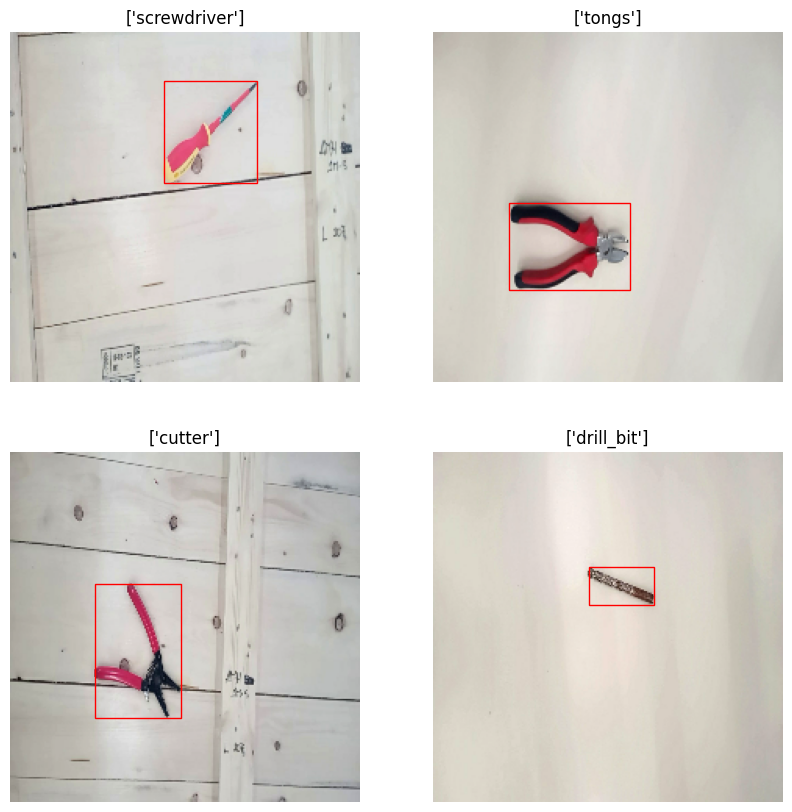

In [ ]:
# Display a sample training image with its label
pyplot.figure(figsize=(10, 10))

for img,label in test_dataset.take(1):
  out1, out2, out3, out4, out5 = label

  for i in range(4):

    ax = pyplot.subplot(2, 2, i + 1)
    plt.imshow(keras.preprocessing.image.array_to_img(img[i]))

    xmin, ymin, xmax, ymax = out1[i].numpy()*SIZE, out2[i].numpy()*SIZE, out3[i].numpy()*SIZE, out4[i].numpy()*SIZE
    rect = Rectangle((xmin,ymin),(xmax - xmin),(ymax - ymin), fill = False, color = "r")
    ax = plt.gca()
    ax.axes.add_patch(rect)
    plt.title([clave for clave, valor in Class_dict.items() if valor == out5[i]+1])
    pyplot.axis("off")

    #plt.show()

## Define model architecture TRANSFORMER


Ejecutaremos el código ViT, pero esta vez hemos introducido ruido en las imágenes para evaluar su impacto en el rendimiento.

In [ ]:
'''
Install in the environment the packages "tensorflow-addons" and "vit-keras"
'''

from vit_keras import vit

base = vit.vit_b32( image_size= SIZE,
                    include_top=False,
                    pretrained_top=False,
                    pretrained=True)

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


353253686/353253686 [==============================] - 2s 0us/step


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


In [ ]:
for layer in base.layers[:12]:
    layer.trainable = False

In [ ]:
# Define the base model with fully-connected layers
inputs = keras.Input(shape = (SIZE,SIZE,3))
x = base(inputs)

x1 = keras.layers.Dense(128, activation = "relu")(x)
x1 = keras.layers.Dense(64, activation = "relu")(x1)

out1 = keras.layers.Dense(64, activation = "relu")(x1)
out1 = keras.layers.Dense(1, name = "xmin")(out1)

out2 = keras.layers.Dense(64, activation = "relu")(x1)
out2 = keras.layers.Dense(1, name = "ymin")(out2)

out3 = keras.layers.Dense(64, activation = "relu")(x1)
out3 = keras.layers.Dense(1, name = "xmax")(out3)

out4 = keras.layers.Dense(64, activation = "relu")(x1)
out4 = keras.layers.Dense(1, name = "ymax")(out4)

x2 = tf.keras.layers.Flatten()(x)
x2 = keras.layers.Dense(32,activation = "relu")(x2)
x2 = keras.layers.Dropout(0.2)(x2)
out_class = keras.layers.Dense(6,activation = "softmax", name = "class")(x2)

out = [out1, out2, out3, out4, out_class]

model = keras.models.Model(inputs = inputs, outputs = out)
model.summary()

out = [out1, out2, out3, out4, out_class]

model = keras.models.Model(inputs = inputs, outputs = out)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 vit-b32 (Functional)        (None, 768)                  8745523   ['input_2[0][0]']             
                                                          2                                       
                                                                                                  
 dense (Dense)               (None, 128)                  98432     ['vit-b32[0][0]']             
                                                                                                  
 flatten (Flatten)           (None, 768)                  0         ['vit-b32[0][0]']         

## Compile and train

In [ ]:
# Compile the model with optimizer and loss functions
model.compile(keras.optimizers.Adam(0.0001),
              loss = {"xmin": 'mse',
                      "ymin": 'mse',
                      "xmax": 'mse',
                      "ymax": 'mse',
                      "class": "sparse_categorical_crossentropy"},
              metrics = ["mae","acc"])

In [ ]:
# callback to save the best model
cb1 = tf.keras.callbacks.ModelCheckpoint(
    os.path.join(path_models,'ViT_loc.h5'), monitor='val_loss', verbose=0, save_best_only=True,
    save_weights_only=False, mode='min', save_freq='epoch'
    )

cb2 = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0.001, patience=80, verbose=0, mode='min',
    baseline=None, restore_best_weights=True
    )

In [ ]:
train_items = len(os.listdir(path_train))/2
valid_items = len(os.listdir(path_valid))/2

# Start training the model
history = model.fit(train_dataset,
                    steps_per_epoch = train_items//batch_train,
                    batch_size=batch_train,
                    epochs = 100,
                    validation_data = valid_dataset,
                    validation_steps = valid_items//batch_valid,
                    callbacks=[cb1,cb2])

Epoch 1/100
26/26 [==============================] - ETA: 0s - loss: 1.6543 - xmin_loss: 0.1781 - ymin_loss: 0.1025 - xmax_loss: 0.1549 - ymax_loss: 0.0972 - class_loss: 1.1216 - xmin_mae: 0.3188 - xmin_acc: 0.0000e+00 - ymin_mae: 0.2485 - ymin_acc: 0.0240 - xmax_mae: 0.2894 - xmax_acc: 0.0000e+00 - ymax_mae: 0.2484 - ymax_acc: 0.0000e+00 - class_mae: 2.3918 - class_acc: 0.6418

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


26/26 [==============================] - 55s 904ms/step - loss: 1.6543 - xmin_loss: 0.1781 - ymin_loss: 0.1025 - xmax_loss: 0.1549 - ymax_loss: 0.0972 - class_loss: 1.1216 - xmin_mae: 0.3188 - xmin_acc: 0.0000e+00 - ymin_mae: 0.2485 - ymin_acc: 0.0240 - xmax_mae: 0.2894 - xmax_acc: 0.0000e+00 - ymax_mae: 0.2484 - ymax_acc: 0.0000e+00 - class_mae: 2.3918 - class_acc: 0.6418 - val_loss: 0.3251 - val_xmin_loss: 0.0526 - val_ymin_loss: 0.0643 - val_xmax_loss: 0.0530 - val_ymax_loss: 0.0501 - val_class_loss: 0.1052 - val_xmin_mae: 0.1922 - val_xmin_acc: 0.0000e+00 - val_ymin_mae: 0.2002 - val_ymin_acc: 0.0341 - val_xmax_mae: 0.1881 - val_xmax_acc: 0.0000e+00 - val_ymax_mae: 0.1657 - val_ymax_acc: 0.0000e+00 - val_class_mae: 2.3788 - val_class_acc: 1.0000
Epoch 2/100
26/26 [==============================] - 7s 275ms/step - loss: 0.2800 - xmin_loss: 0.0287 - ymin_loss: 0.0496 - xmax_loss: 0.0403 - ymax_loss: 0.0496 - class_loss: 0.1119 - xmin_mae: 0.1347 - xmin_acc: 0.0000e+00 - ymin_mae: 0.1

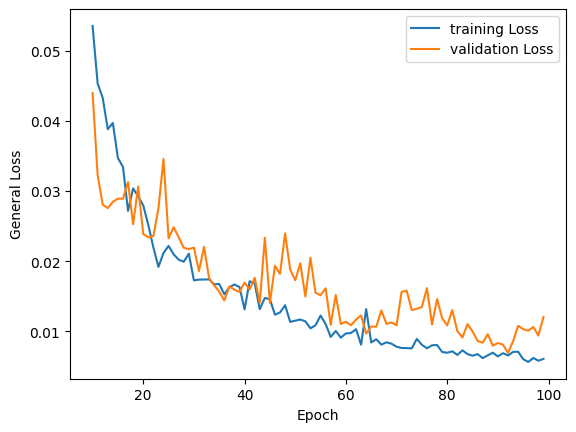

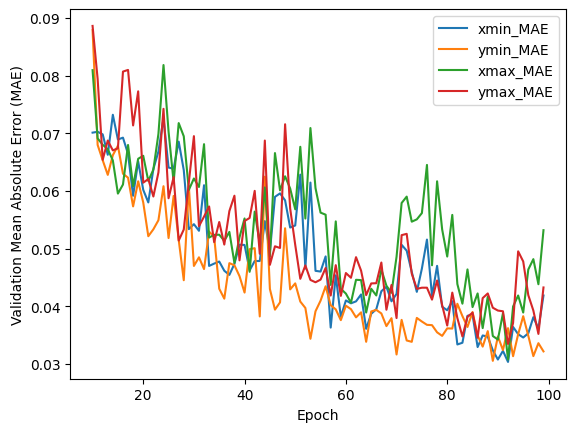

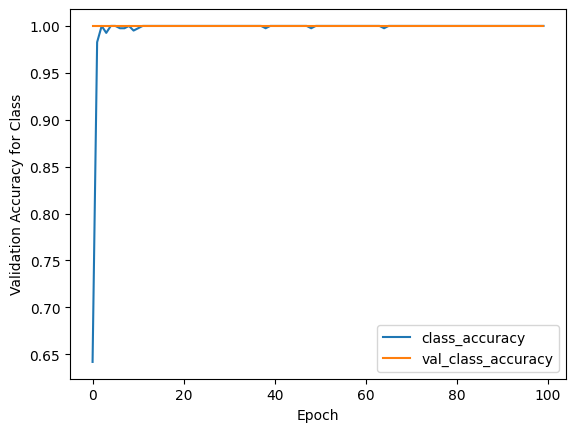

In [ ]:
# Visualize the results after training
flag = 10

def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist["epoch"] = history.epoch

    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("General Loss")
    plt.plot(hist["epoch"][flag:], hist["loss"][flag:], label = "training Loss")
    plt.plot(hist["epoch"][flag:], hist["val_loss"][flag:], label = "validation Loss")
    plt.legend()

    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Validation Mean Absolute Error (MAE)")
    plt.plot(hist["epoch"][flag:], hist["val_xmin_mae"][flag:], label = "xmin_MAE")
    plt.plot(hist["epoch"][flag:], hist["val_ymin_mae"][flag:], label = "ymin_MAE")
    plt.plot(hist["epoch"][flag:], hist["val_xmax_mae"][flag:], label = "xmax_MAE")
    plt.plot(hist["epoch"][flag:], hist["val_ymax_mae"][flag:], label = "ymax_MAE")
    plt.legend()

    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Validation Accuracy for Class")
    plt.plot(hist["epoch"],hist["class_acc"], label = "class_accuracy")
    plt.plot(hist["epoch"],hist["val_class_acc"], label = "val_class_accuracy")
    plt.legend()

    plt.show()

plot_history(history)

In [ ]:
test_items = len(os.listdir(path_test))/2

results = model.evaluate(test_dataset, steps = test_items/batch_valid)

22/22 [==============================] - 2s 55ms/step - loss: 0.0092 - xmin_loss: 0.0018 - ymin_loss: 0.0025 - xmax_loss: 0.0027 - ymax_loss: 0.0021 - class_loss: 2.6504e-06 - xmin_mae: 0.0357 - xmin_acc: 0.0000e+00 - ymin_mae: 0.0425 - ymin_acc: 0.0111 - xmax_mae: 0.0415 - xmax_acc: 0.0000e+00 - ymax_mae: 0.0357 - ymax_acc: 0.0000e+00 - class_mae: 2.3889 - class_acc: 1.0000


In [ ]:
print("MAE of xmin value in test set:{}".format(results[6]))
print("MAE of ymin value in test set:{}".format(results[8]))
print("MAE of xmax value in test set:{}".format(results[10]))
print("MAE of ymax value in test set:{}".format(results[12]))
print("Testing accuracy of predicted label:{}".format(results[15]))

MAE of xmin value in test set:0.03571205213665962
MAE of ymin value in test set:0.04251614585518837
MAE of xmax value in test set:0.041504908353090286
MAE of ymax value in test set:0.03574415668845177
Testing accuracy of predicted label:1.0


Conclusión:

Se ha notado un deterioro en el rendimiento de ViT al introducir ruido en las imágenes, a pesar de que la similitud con las originales es notable. Las comparaciones detalladas se encuentran en el archivo 'Comparasion'.

## BUSCANDO UN MEJOR MODELO

---

En este notebook, se han empleado varios modelos para el procesamiento y análisis de imágenes. Además de algunos modelos como ResNet152 y DenseNet, los cuales se ha preferido no incluirlos debido a su desempeño menos favorable en comparación con los modelos seleccionados.

Por lo tanto, los modelos seleccionados han sido ViT y EfficientNet en sus versiones B6 y B7. Dada la cantidad de modelos, realizaré una explicación general sobre por qué elegí EfficientNet y me centraré en explicar únicamente ViT, incluyendo su modelo B6 y la versión final.

¿Por qué EfficientNetB7?

EfficientNetB7 se destaca por ser uno de los modelos de redes neuronales convolucionales más potentes y eficientes en términos de rendimiento computacional y precisión en tareas de visión.

Algunos de sus puntos más relevantes:

1.- Arquitectura escalable y equilibrada: La serie EfficientNet se caracteriza por un enfoque de escalabilidad que mantienen un equilibrio óptimo entre el número de parámetros, la profundidad y el ancho de la red, llevando a un mejor rendimiento en relación con la complejidad del modelo.

2.- Mejora del rendimiento: EfficientNetB7, al ser el modelo más grande y complejo dentro de la serie EfficientNet, tiende a ofrecer un rendimiento mejorado en comparación con sus contrapartes más pequeñas.

3.- Transferencia de aprendizaje: Debido a su entrenamiento en conjuntos de datos masivos y su arquitectura eficiente, EfficientNetB7 es una opción sólida para la transferencia de aprendizaje.

In [ ]:
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Flatten
from tensorflow.keras.models import Model

# Define input size
SIZE = 224  # Set your desired input size here

# Load EfficientNetB4 as the base model
base_model = EfficientNetB7(input_shape=(SIZE, SIZE, 3), include_top=False, weights='imagenet')

# Freeze the layers of the base model
for layer in base_model.layers[:12]:
    layer.trainable = False

# Define the input layer
inputs = Input(shape=(SIZE, SIZE, 3))

# Pass the input through the base model
x = base_model(inputs)

# Add Dense layers with BatchNormalization and Dropout for improved performance¡
x1 = keras.layers.Dense(128, activation="relu")(x)
x1 = keras.layers.Dense(64, activation="relu")(x1)

# Output layers for object detection (xmin, ymin, xmax, ymax)
out1 = keras.layers.Dense(32, activation="relu")(x1)
out1 = keras.layers.Dense(1, name="xmin")(out1)

out2 = keras.layers.Dense(32, activation="relu")(x1)
out2 = keras.layers.Dense(1, name="ymin")(out2)

out3 = keras.layers.Dense(32, activation="relu")(x1)
out3 = keras.layers.Dense(1, name="xmax")(out3)

out4 = keras.layers.Dense(32, activation="relu")(x1)
out4 = keras.layers.Dense(1, name="ymax")(out4)

# Flatten layer for classification
x2 = tf.keras.layers.Flatten()(x)
x2 = keras.layers.Dense(16, activation="relu")(x2)

# Output layer for class classification
out_class = Dense(6, activation="softmax", name="class")(x2)

# Define the outputs
out = [out1, out2, out3, out4, out_class]

# Create the model
model = Model(inputs=inputs, outputs=out)

# Display model summary
model.summary()

258076736/258076736 [==============================] - 12s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 efficientnetb7 (Functional  (None, 7, 7, 2560)           6409768   ['input_2[0][0]']             
 )                                                        7                                       
                                                                                                  
 global_average_pooling2d (  (None, 2560)                 0         ['efficientnetb7[0][0]']      
 GlobalAveragePooling2D)                                                                          
                          

In [ ]:
model.compile(keras.optimizers.Adam(0.0001),
              loss = {"xmin": 'mse',
                      "ymin": 'mse',
                      "xmax": 'mse',
                      "ymax": 'mse',
                      "class": "sparse_categorical_crossentropy"},
              metrics = ["mae","acc"])

In [ ]:
# callback to save the best model
cb1 = tf.keras.callbacks.ModelCheckpoint(
    os.path.join(path_models,'EfficientNetB7.h5'), monitor='val_loss', verbose=0, save_best_only=True,
    save_weights_only=False, mode='min', save_freq='epoch'
    )

cb2 = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0.001, patience=20, verbose=0, mode='min',
    baseline=None, restore_best_weights=True
    )

In [ ]:
train_items = len(os.listdir(path_train))/2
valid_items = len(os.listdir(path_valid))/2

# Start training the model
history = model.fit(train_dataset,
                    steps_per_epoch = train_items//batch_train,
                    batch_size=batch_train,
                    epochs = 100,
                    validation_data = valid_dataset,
                    validation_steps = valid_items//batch_valid,
                    callbacks=[cb1,cb2])

Epoch 1/100
26/26 [==============================] - ETA: 0s - loss: 1.9100 - xmin_loss: 0.1364 - ymin_loss: 0.1267 - xmax_loss: 0.2832 - ymax_loss: 0.2749 - class_loss: 1.0889 - xmin_mae: 0.3171 - xmin_acc: 0.0000e+00 - ymin_mae: 0.2945 - ymin_acc: 0.0264 - xmax_mae: 0.4885 - xmax_acc: 0.0000e+00 - ymax_mae: 0.4662 - ymax_acc: 0.0000e+00 - class_mae: 2.3862 - class_acc: 0.5697

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


26/26 [==============================] - 211s 2s/step - loss: 1.9100 - xmin_loss: 0.1364 - ymin_loss: 0.1267 - xmax_loss: 0.2832 - ymax_loss: 0.2749 - class_loss: 1.0889 - xmin_mae: 0.3171 - xmin_acc: 0.0000e+00 - ymin_mae: 0.2945 - ymin_acc: 0.0264 - xmax_mae: 0.4885 - xmax_acc: 0.0000e+00 - ymax_mae: 0.4662 - ymax_acc: 0.0000e+00 - class_mae: 2.3862 - class_acc: 0.5697 - val_loss: 6.0886 - val_xmin_loss: 0.0559 - val_ymin_loss: 0.0984 - val_xmax_loss: 0.0121 - val_ymax_loss: 0.0288 - val_class_loss: 5.8935 - val_xmin_mae: 0.2099 - val_xmin_acc: 0.0000e+00 - val_ymin_mae: 0.2546 - val_ymin_acc: 0.0341 - val_xmax_mae: 0.0852 - val_xmax_acc: 0.0000e+00 - val_ymax_mae: 0.1415 - val_ymax_acc: 0.0000e+00 - val_class_mae: 2.3674 - val_class_acc: 0.1705
Epoch 2/100
26/26 [==============================] - 23s 917ms/step - loss: 0.3812 - xmin_loss: 0.0373 - ymin_loss: 0.0336 - xmax_loss: 0.0574 - ymax_loss: 0.0592 - class_loss: 0.1936 - xmin_mae: 0.1512 - xmin_acc: 0.0000e+00 - ymin_mae: 0.14

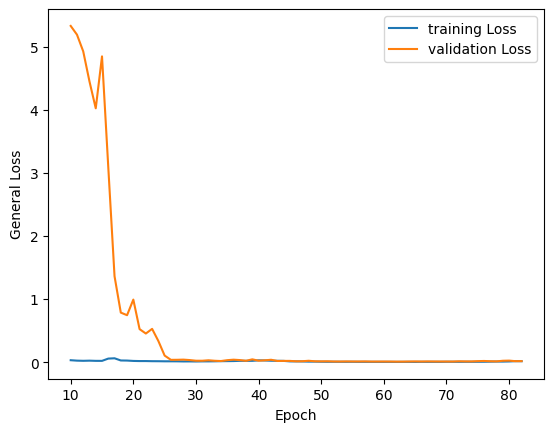

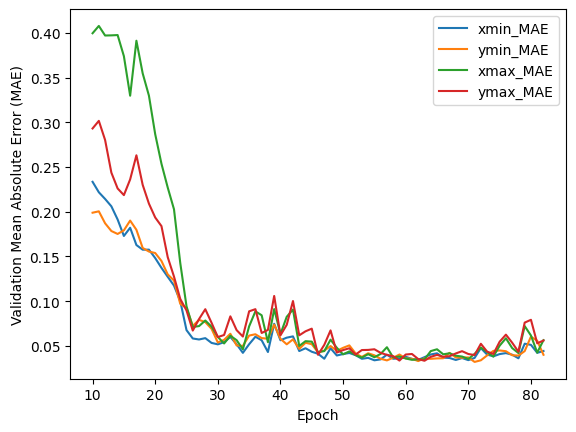

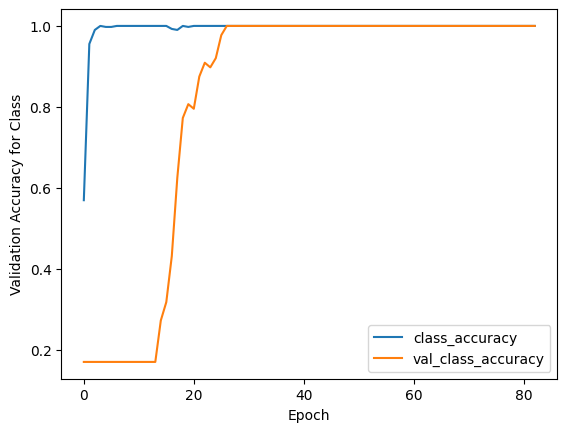

In [ ]:
# Visualize the results after training
flag = 10

def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist["epoch"] = history.epoch

    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("General Loss")
    plt.plot(hist["epoch"][flag:], hist["loss"][flag:], label = "training Loss")
    plt.plot(hist["epoch"][flag:], hist["val_loss"][flag:], label = "validation Loss")
    plt.legend()

    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Validation Mean Absolute Error (MAE)")
    plt.plot(hist["epoch"][flag:], hist["val_xmin_mae"][flag:], label = "xmin_MAE")
    plt.plot(hist["epoch"][flag:], hist["val_ymin_mae"][flag:], label = "ymin_MAE")
    plt.plot(hist["epoch"][flag:], hist["val_xmax_mae"][flag:], label = "xmax_MAE")
    plt.plot(hist["epoch"][flag:], hist["val_ymax_mae"][flag:], label = "ymax_MAE")
    plt.legend()

    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Validation Accuracy for Class")
    plt.plot(hist["epoch"],hist["class_acc"], label = "class_accuracy")
    plt.plot(hist["epoch"],hist["val_class_acc"], label = "val_class_accuracy")
    plt.legend()

    plt.show()

plot_history(history)

## Model evaluation

In [ ]:
test_items = len(os.listdir(path_test))/2

results = model.evaluate(test_dataset, steps = test_items/batch_valid)

22/22 [==============================] - 4s 137ms/step - loss: 0.0077 - xmin_loss: 0.0018 - ymin_loss: 0.0016 - xmax_loss: 0.0026 - ymax_loss: 0.0018 - class_loss: 3.0197e-05 - xmin_mae: 0.0310 - xmin_acc: 0.0000e+00 - ymin_mae: 0.0334 - ymin_acc: 0.0111 - xmax_mae: 0.0386 - xmax_acc: 0.0000e+00 - ymax_mae: 0.0330 - ymax_acc: 0.0000e+00 - class_mae: 2.3889 - class_acc: 1.0000


In [ ]:
print("MAE of xmin value in test set:{}".format(results[6]))
print("MAE of ymin value in test set:{}".format(results[8]))
print("MAE of xmax value in test set:{}".format(results[10]))
print("MAE of ymax value in test set:{}".format(results[12]))
print("Testing accuracy of predicted label:{}".format(results[15]))

MAE of xmin value in test set:0.03103923611342907
MAE of ymin value in test set:0.03343919292092323
MAE of xmax value in test set:0.038586802780628204
MAE of ymax value in test set:0.03301769495010376
Testing accuracy of predicted label:1.0


1/1 [==============================] - 5s 5s/step


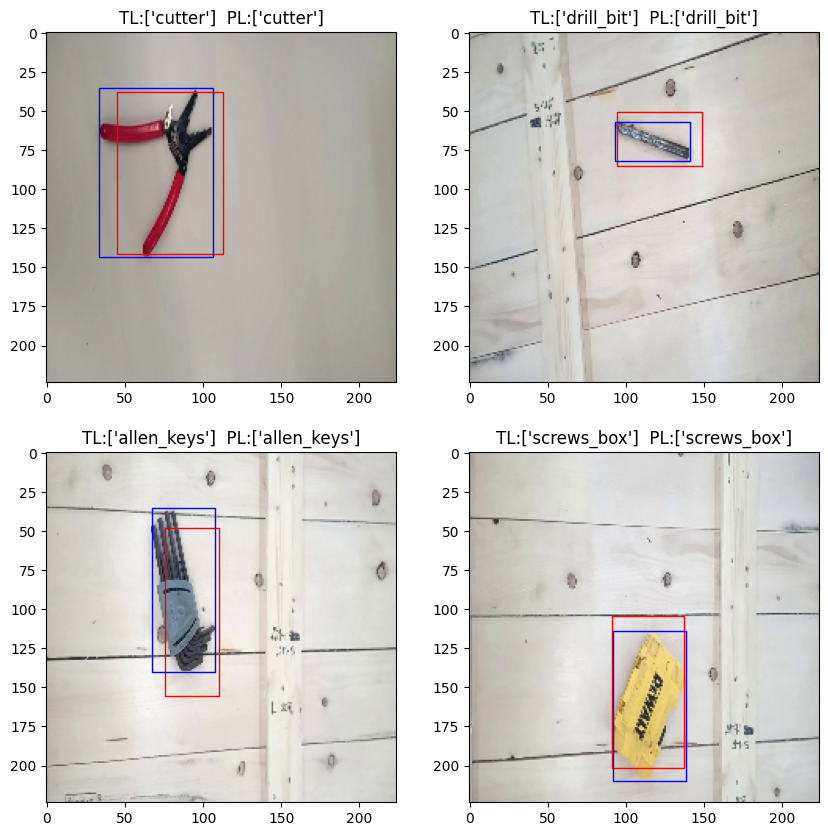

In [ ]:
# BLUE rectangle is ground truth
# RED rectangle is the prediction

plt.figure(figsize = (10,10))

for img, GT in test_dataset.take(1):
    out1, out2, out3, out4, out5 = model.predict(img)
    out1_gt, out2_gt, out3_gt, out4_gt, out5_gt = GT


    for i in range(4):

        plt.subplot(2, 2, i + 1)
        plt.imshow(keras.preprocessing.image.array_to_img(img[i]))

        plt.title('TL:{0}  PL:{1}'.format([clave for clave, valor in Class_dict.items() if valor == out5_gt[i]+1], [clave for clave, valor in Class_dict.items() if valor == np.argmax(out5[i])+1]))

        xmin, ymin, xmax, ymax = out1[i]*SIZE, out2[i]*SIZE, out3[i]*SIZE, out4[i]*SIZE
        rect = Rectangle((xmin,ymin), (xmax - xmin), (ymax - ymin), fill = False, color = "r")

        xmin, ymin, xmax, ymax = out1_gt[i]*SIZE, out2_gt[i]*SIZE, out3_gt[i]*SIZE, out4_gt[i]*SIZE
        rect2 = Rectangle((xmin,ymin), (xmax - xmin), (ymax - ymin), fill = False, color = "b")

        ax = plt.gca()
        ax.axes.add_patch(rect)
        ax.axes.add_patch(rect2)

## LOCALIZATION IS GOOD

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def tecnun_report_loc(model, dataframe, dict_labels):

    true_labels, pred_labels = [], []
    for image, label in dataframe:
        _,_,_,_, out5 = label
        _,_,_,_, pred = model.predict(image, verbose=0)
        for element in out5:
            true_labels.append(dict_labels[element])
        for element in pred:
            pred_labels.append(dict_labels[np.argmax(element)])

    print(classification_report(true_labels, pred_labels))


def tecnun_matrix_loc(model, dataframe, dict_labels):

    true_labels, pred_labels = [], []
    for image, label in dataframe:
        _,_,_,_, out5 = label
        _,_,_,_, pred = model.predict(image, verbose=0)
        for element in out5:
            true_labels.append(dict_labels[element])
        for element in pred:
            pred_labels.append(dict_labels[np.argmax(element)])

    cf = confusion_matrix(true_labels, pred_labels, labels= dict_labels)

    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(cf, annot=True, fmt="", square=True, cbar=False,
              cmap=plt.cm.Blues, xticklabels=dict_labels, yticklabels=dict_labels, ax = ax)
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    ax.set_title('Confusion Matrix')
    plt.show()

In [ ]:
tecnun_report_loc(model, test_dataset, dict_labels)

              precision    recall  f1-score   support

  allen_keys       1.00      1.00      1.00        15
      cutter       1.00      1.00      1.00        15
   drill_bit       1.00      1.00      1.00        15
 screwdriver       1.00      1.00      1.00        15
  screws_box       1.00      1.00      1.00        15
       tongs       1.00      1.00      1.00        15

    accuracy                           1.00        90
   macro avg       1.00      1.00      1.00        90
weighted avg       1.00      1.00      1.00        90



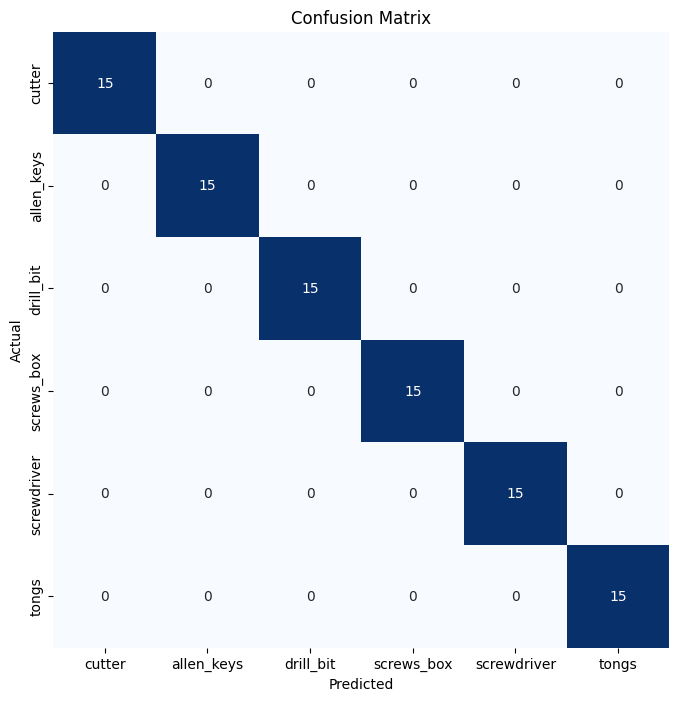

In [ ]:
tecnun_matrix_loc(model, test_dataset, dict_labels)

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.layers import Dense, BatchNormalization

# Capa de entrada
inputs = tf.keras.Input(shape=(SIZE, SIZE, 3))

# Utilizar ResNet50 pre-entrenado como extractor de características base
base = EfficientNetB7(weights='imagenet', include_top=False)
x = base(inputs)

x0 = keras.layers.Dense(128, activation="relu")(x)
x0 = keras.layers.Dense(64, activation="relu")(x0)

# Capas para las coordenadas de las bounding boxes (xmin, ymin, xmax, ymax)
x1 = tf.keras.layers.GlobalAveragePooling2D()(x0)
x1 = tf.keras.layers.Dense(128, activation='relu')(x1)
x1 = tf.keras.layers.BatchNormalization()(x1)
x1 = tf.keras.layers.Dense(64, activation='relu')(x1)
x1 = tf.keras.layers.BatchNormalization()(x1)
out_xmin = tf.keras.layers.Dense(1, name='xmin')(x1)

x2 = tf.keras.layers.GlobalAveragePooling2D()(x0)
x2 = tf.keras.layers.Dense(128, activation='relu')(x2)
x2 = tf.keras.layers.BatchNormalization()(x2)
x2 = tf.keras.layers.Dense(64, activation='relu')(x2)
x2 = tf.keras.layers.BatchNormalization()(x2)
out_ymin = tf.keras.layers.Dense(1, name='ymin')(x2)

x3 = tf.keras.layers.GlobalAveragePooling2D()(x0)
x3 = tf.keras.layers.Dense(128, activation='relu')(x3)
x3 = tf.keras.layers.BatchNormalization()(x3)
x3 = tf.keras.layers.Dense(64, activation='relu')(x3)
x3 = tf.keras.layers.BatchNormalization()(x3)
out_xmax = tf.keras.layers.Dense(1, name='xmax')(x3)

x4 = tf.keras.layers.GlobalAveragePooling2D()(x0)
x4 = tf.keras.layers.Dense(128, activation='relu')(x4)
x4 = tf.keras.layers.BatchNormalization()(x4)
x4 = tf.keras.layers.Dense(64, activation='relu')(x4)
x4 = tf.keras.layers.BatchNormalization()(x4)
out_ymax = tf.keras.layers.Dense(1, name='ymax')(x4)

# Capas para la clasificación de clases
x5 = tf.keras.layers.Flatten()(x)
x5 = tf.keras.layers.Dense(64, activation='relu')(x5)
x5 = tf.keras.layers.Dropout(0.2)(x5)
out_class = tf.keras.layers.Dense(6, activation='softmax', name='class')(x5)

# Salidas del modelo
outputs = [out_xmin, out_ymin, out_xmax, out_ymax, out_class]

# Crear el modelo
model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
model.summary()


258076736/258076736 [==============================] - 6s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 efficientnetb7 (Functional  (None, None, None, 2560)     6409768   ['input_5[0][0]']             
 )                                                        7                                       
                                                                                                  
 dense_18 (Dense)            (None, 7, 7, 128)            327808    ['efficientnetb7[0][0]']      
                                                                                                  
 dense_19 (Dense)        

In [ ]:
model.compile(keras.optimizers.Adam(0.0001),
              loss = {"xmin": 'mse',
                      "ymin": 'mse',
                      "xmax": 'mse',
                      "ymax": 'mse',
                      "class": "sparse_categorical_crossentropy"},
              metrics = ["mae","acc"])

In [ ]:
# callback to save the best model
cb1 = tf.keras.callbacks.ModelCheckpoint(
    os.path.join(path_models,'EfficientNetB7_new.h5'), monitor='val_loss', verbose=0, save_best_only=True,
    save_weights_only=False, mode='min', save_freq='epoch'
    )

cb2 = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0.001, patience=20, verbose=0, mode='min',
    baseline=None, restore_best_weights=True
    )

In [ ]:
train_items = len(os.listdir(path_train))/2
valid_items = len(os.listdir(path_valid))/2

# Start training the model
history = model.fit(train_dataset,
                    steps_per_epoch = train_items//batch_train,
                    batch_size=batch_train,
                    epochs = 100,
                    validation_data = valid_dataset,
                    validation_steps = valid_items//batch_valid,
                    callbacks=[cb1,cb2])

Epoch 1/100
26/26 [==============================] - ETA: 0s - loss: 7.8439 - xmin_loss: 1.5697 - ymin_loss: 1.5556 - xmax_loss: 2.0111 - ymax_loss: 1.8366 - class_loss: 0.8708 - xmin_mae: 1.0199 - xmin_acc: 0.0000e+00 - ymin_mae: 0.9952 - ymin_acc: 0.0120 - xmax_mae: 1.1476 - xmax_acc: 0.0000e+00 - ymax_mae: 1.0673 - ymax_acc: 0.0000e+00 - class_mae: 2.3902 - class_acc: 0.7091

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


26/26 [==============================] - 217s 3s/step - loss: 7.8439 - xmin_loss: 1.5697 - ymin_loss: 1.5556 - xmax_loss: 2.0111 - ymax_loss: 1.8366 - class_loss: 0.8708 - xmin_mae: 1.0199 - xmin_acc: 0.0000e+00 - ymin_mae: 0.9952 - ymin_acc: 0.0120 - xmax_mae: 1.1476 - xmax_acc: 0.0000e+00 - ymax_mae: 1.0673 - ymax_acc: 0.0000e+00 - class_mae: 2.3902 - class_acc: 0.7091 - val_loss: 10.8705 - val_xmin_loss: 0.2583 - val_ymin_loss: 0.0389 - val_xmax_loss: 0.1722 - val_ymax_loss: 0.2732 - val_class_loss: 10.1279 - val_xmin_mae: 0.4952 - val_xmin_acc: 0.0000e+00 - val_ymin_mae: 0.1686 - val_ymin_acc: 0.0341 - val_xmax_mae: 0.4001 - val_xmax_acc: 0.0000e+00 - val_ymax_mae: 0.4941 - val_ymax_acc: 0.0000e+00 - val_class_mae: 2.3561 - val_class_acc: 0.1705
Epoch 2/100
26/26 [==============================] - 25s 991ms/step - loss: 4.7646 - xmin_loss: 1.1863 - ymin_loss: 0.8098 - xmax_loss: 1.3330 - ymax_loss: 1.3069 - class_loss: 0.1285 - xmin_mae: 0.8810 - xmin_acc: 0.0000e+00 - ymin_mae: 0.

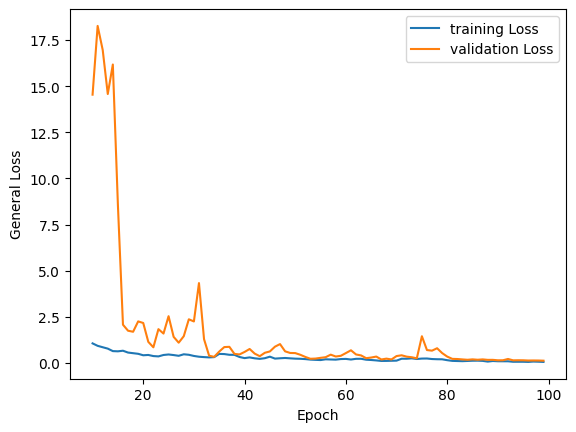

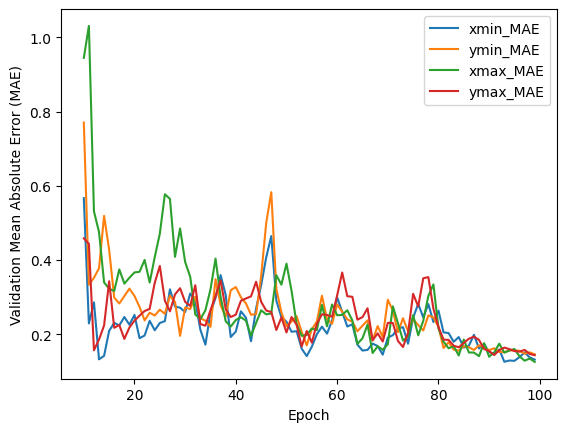

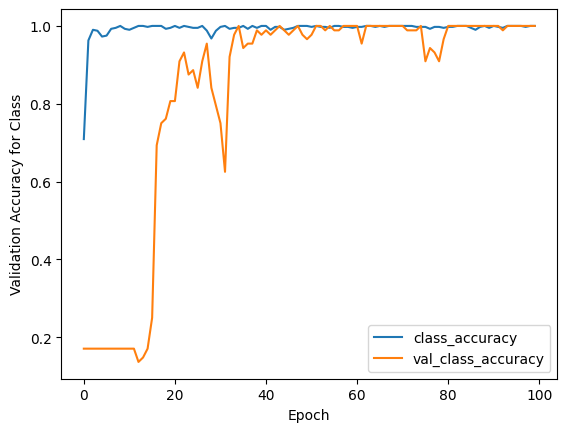

In [ ]:
# Visualize the results after training
flag = 10

def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist["epoch"] = history.epoch

    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("General Loss")
    plt.plot(hist["epoch"][flag:], hist["loss"][flag:], label = "training Loss")
    plt.plot(hist["epoch"][flag:], hist["val_loss"][flag:], label = "validation Loss")
    plt.legend()

    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Validation Mean Absolute Error (MAE)")
    plt.plot(hist["epoch"][flag:], hist["val_xmin_mae"][flag:], label = "xmin_MAE")
    plt.plot(hist["epoch"][flag:], hist["val_ymin_mae"][flag:], label = "ymin_MAE")
    plt.plot(hist["epoch"][flag:], hist["val_xmax_mae"][flag:], label = "xmax_MAE")
    plt.plot(hist["epoch"][flag:], hist["val_ymax_mae"][flag:], label = "ymax_MAE")
    plt.legend()

    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Validation Accuracy for Class")
    plt.plot(hist["epoch"],hist["class_acc"], label = "class_accuracy")
    plt.plot(hist["epoch"],hist["val_class_acc"], label = "val_class_accuracy")
    plt.legend()

    plt.show()

plot_history(history)

In [ ]:
test_items = len(os.listdir(path_test))/2

results = model.evaluate(test_dataset, steps = test_items/batch_valid)

22/22 [==============================] - 3s 128ms/step - loss: 0.1102 - xmin_loss: 0.0226 - ymin_loss: 0.0279 - xmax_loss: 0.0292 - ymax_loss: 0.0305 - class_loss: 2.6491e-09 - xmin_mae: 0.1143 - xmin_acc: 0.0000e+00 - ymin_mae: 0.1337 - ymin_acc: 0.0111 - xmax_mae: 0.1332 - xmax_acc: 0.0000e+00 - ymax_mae: 0.1437 - ymax_acc: 0.0000e+00 - class_mae: 2.3889 - class_acc: 1.0000


In [ ]:
print("MAE of xmin value in test set:{}".format(results[6]))
print("MAE of ymin value in test set:{}".format(results[8]))
print("MAE of xmax value in test set:{}".format(results[10]))
print("MAE of ymax value in test set:{}".format(results[12]))
print("Testing accuracy of predicted label:{}".format(results[15]))

MAE of xmin value in test set:0.11426112800836563
MAE of ymin value in test set:0.133659228682518
MAE of xmax value in test set:0.13315042853355408
MAE of ymax value in test set:0.14370273053646088
Testing accuracy of predicted label:1.0


## EFFICIENTNET B6

---

Elegimos EfficientNetB6 para verificar si el modelo mejora al utilizar BatchNormalization y, al mismo tiempo, para evaluar si la versión B6 muestra un buen rendimiento para esta tarea específica.

Utilizamos los pesos preentrenados de ImageNet. Estos pesos representan las características aprendidas por el modelo al reconocer patrones en una amplia gama de imágenes del conjunto de datos de ImageNet.

In [ ]:
from tensorflow.keras.applications import EfficientNetB6
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Flatten
from tensorflow.keras.models import Model

# Define input size
SIZE = 224  # Set your desired input size here

# Load EfficientNetB4 as the base model
base_model = EfficientNetB6(input_shape=(SIZE, SIZE, 3), include_top=False, weights='imagenet')

# Freeze the layers of the base model
for layer in base_model.layers[:12]:
    layer.trainable = False

# Define the input layer
inputs = Input(shape=(SIZE, SIZE, 3))

# Pass the input through the base model
x = base_model(inputs)

# Add Dense layers with BatchNormalization and Dropout for improved performance¡
x1 = keras.layers.Dense(128, activation="relu")(x)
x1 = keras.layers.Dense(64, activation="relu")(x1)
x1 = keras.layers.BatchNormalization()(x1)

# Output layers for object detection (xmin, ymin, xmax, ymax)
out1 = keras.layers.Dense(64, activation="relu")(x1)
out1 = keras.layers.Dense(1, name="xmin")(out1)

out2 = keras.layers.Dense(64, activation="relu")(x1)
out2 = keras.layers.Dense(1, name="ymin")(out2)

out3 = keras.layers.Dense(64, activation="relu")(x1)
out3 = keras.layers.Dense(1, name="xmax")(out3)

out4 = keras.layers.Dense(64, activation="relu")(x1)
out4 = keras.layers.Dense(1, name="ymax")(out4)

# Flatten layer for classification
x2 = tf.keras.layers.Flatten()(x)
x2 = keras.layers.Dense(64, activation="relu")(x2)
x2 = keras.layers.BatchNormalization()(x2)

# Output layer for class classification
out_class = Dense(6, activation="softmax", name="class")(x2)

# Define the outputs
out = [out1, out2, out3, out4, out_class]

# Create the model
model = Model(inputs=inputs, outputs=out)

# Display model summary
model.summary()

165234480/165234480 [==============================] - 2s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 efficientnetb6 (Functional  (None, 7, 7, 2304)           4096014   ['input_4[0][0]']             
 )                                                        3                                       
                                                                                                  
 dense_11 (Dense)            (None, 7, 7, 64)             147520    ['efficientnetb6[0][0]']      
                                                                                                  
 dense_12 (Dense)        

In [ ]:
model.compile(keras.optimizers.Adam(0.0001),
              loss = {"xmin": 'mse',
                      "ymin": 'mse',
                      "xmax": 'mse',
                      "ymax": 'mse',
                      "class": "sparse_categorical_crossentropy"},
              metrics = ["mae","acc"])

In [ ]:
# callback to save the best model
cb1 = tf.keras.callbacks.ModelCheckpoint(
    os.path.join(path_models,'EfficientNetB7_new.h5'), monitor='val_loss', verbose=0, save_best_only=True,
    save_weights_only=False, mode='min', save_freq='epoch'
    )

cb2 = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0.001, patience=20, verbose=0, mode='min',
    baseline=None, restore_best_weights=True
    )

In [ ]:
train_items = len(os.listdir(path_train))/2
valid_items = len(os.listdir(path_valid))/2

# Start training the model
history = model.fit(train_dataset,
                    steps_per_epoch = train_items//batch_train,
                    batch_size=batch_train,
                    epochs = 100,
                    validation_data = valid_dataset,
                    validation_steps = valid_items//batch_valid,
                    callbacks=[cb1,cb2])

Epoch 1/100
26/26 [==============================] - ETA: 0s - loss: 2.0926 - xmin_loss: 0.5123 - ymin_loss: 0.1241 - xmax_loss: 0.1817 - ymax_loss: 0.3334 - class_loss: 0.9411 - xmin_mae: 0.6066 - xmin_acc: 0.0000e+00 - ymin_mae: 0.2832 - ymin_acc: 0.0249 - xmax_mae: 0.3494 - xmax_acc: 0.0000e+00 - ymax_mae: 0.5136 - ymax_acc: 0.0000e+00 - class_mae: 2.3902 - class_acc: 0.6346

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


26/26 [==============================] - 151s 2s/step - loss: 2.0926 - xmin_loss: 0.5123 - ymin_loss: 0.1241 - xmax_loss: 0.1817 - ymax_loss: 0.3334 - class_loss: 0.9411 - xmin_mae: 0.6066 - xmin_acc: 0.0000e+00 - ymin_mae: 0.2832 - ymin_acc: 0.0249 - xmax_mae: 0.3494 - xmax_acc: 0.0000e+00 - ymax_mae: 0.5136 - ymax_acc: 0.0000e+00 - class_mae: 2.3902 - class_acc: 0.6346 - val_loss: 10.2338 - val_xmin_loss: 0.3370 - val_ymin_loss: 0.8536 - val_xmax_loss: 3.5829 - val_ymax_loss: 0.3542 - val_class_loss: 5.1060 - val_xmin_mae: 0.2715 - val_xmin_acc: 0.0000e+00 - val_ymin_mae: 0.3756 - val_ymin_acc: 0.0313 - val_xmax_mae: 0.6566 - val_xmax_acc: 0.0000e+00 - val_ymax_mae: 0.3527 - val_ymax_acc: 0.0000e+00 - val_class_mae: 2.3561 - val_class_acc: 0.1705
Epoch 2/100
26/26 [==============================] - 27s 1s/step - loss: 0.5880 - xmin_loss: 0.1252 - ymin_loss: 0.0871 - xmax_loss: 0.1039 - ymax_loss: 0.1677 - class_loss: 0.1041 - xmin_mae: 0.2730 - xmin_acc: 0.0000e+00 - ymin_mae: 0.2299

In [ ]:
test_items = len(os.listdir(path_test))/2

results = model.evaluate(test_dataset, steps = test_items/batch_valid)

22/22 [==============================] - 3s 119ms/step - loss: 0.1037 - xmin_loss: 0.0121 - ymin_loss: 0.0410 - xmax_loss: 0.0122 - ymax_loss: 0.0384 - class_loss: 1.1868e-06 - xmin_mae: 0.0877 - xmin_acc: 0.0000e+00 - ymin_mae: 0.1744 - ymin_acc: 0.0111 - xmax_mae: 0.0848 - xmax_acc: 0.0000e+00 - ymax_mae: 0.1667 - ymax_acc: 0.0000e+00 - class_mae: 2.3889 - class_acc: 1.0000


In [ ]:
print("MAE of xmin value in test set:{}".format(results[6]))
print("MAE of ymin value in test set:{}".format(results[8]))
print("MAE of xmax value in test set:{}".format(results[10]))
print("MAE of ymax value in test set:{}".format(results[12]))
print("Testing accuracy of predicted label:{}".format(results[15]))

MAE of xmin value in test set:0.08771719038486481
MAE of ymin value in test set:0.17444606125354767
MAE of xmax value in test set:0.08476845175027847
MAE of ymax value in test set:0.16671377420425415
Testing accuracy of predicted label:1.0


## EFFICIENTNETB7 CON RELGUARIZACIÓN

---

A lo largo de los modelos, se ha optado por continuar con una arquitectura muy similar a la utilizada en el modelo ViT, la cual es altamente eficiente. Por lo tanto, no es necesario realizar cambios significativos en sus parámetros.

Sin embargo, se han observado algunas diferencias claras que también se han destacado anteriormente.

1.- Se emplearon pesos preentrenados de ImageNet, los cuales representan las características aprendidas por el modelo al reconocer patrones en una amplia gama de imágenes del conjunto de datos de ImageNet.

2.- Se añadieron dos técnicas de regularización antes de la última capa del modelo: Batch Normalization y Dropout."

In [ ]:
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Model


SIZE = 224  # Tamaño de entrada

# Cargamos EfficientNet como base
base = EfficientNetB7(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))

inputs = Input(shape=(SIZE, SIZE, 3))

# Obtain the output from the base model
x = base(inputs, training=False)

x1 = Flatten()(x)
x1 = Dense(128, activation="relu")(x1)
x1 = Dense(64, activation="relu")(x1)

out1 = Dense(64, activation="relu")(x1)
out1 = Dense(1, name="xmin")(out1)

out2 = Dense(64, activation="relu")(x1)
out2 = Dense(1, name="ymin")(out2)

out3 = Dense(64, activation="relu")(x1)
out3 = Dense(1, name="xmax")(out3)

out4 = Dense(64, activation="relu")(x1)
out4 = Dense(1, name="ymax")(out4)

x2 = Flatten()(x)
x2 = Dense(32, activation="relu")(x2)
x2 = Dropout(0.2)(x2)
x2 = BatchNormalization()(x2)
out_class = Dense(6, activation="softmax", name="class")(x2)

# Definimios los outpus
outputs = [out1, out2, out3, out4, out_class]

model = Model(inputs=inputs, outputs=outputs)
model.summary()


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 efficientnetb7 (Functional  (None, 7, 7, 2560)           6409768   ['input_8[0][0]']             
 )                                                        7                                       
                                                                                                  
 flatten_6 (Flatten)         (None, 125440)               0         ['efficientnetb7[0][0]']      
                                                                                                  
 flatten_7 (Flatten)         (None, 125440)               0         ['efficientnetb7[0][0]']

In [ ]:
model.compile(keras.optimizers.Adam(0.0001),
              loss = {"xmin": 'mse',
                      "ymin": 'mse',
                      "xmax": 'mse',
                      "ymax": 'mse',
                      "class": "sparse_categorical_crossentropy"},
              metrics = ["mae","acc"])

In [ ]:
# callback to save the best model
cb1 = tf.keras.callbacks.ModelCheckpoint(
    os.path.join(path_models,'EfficientNetB0.h5'), monitor='val_loss', verbose=0, save_best_only=True,
    save_weights_only=False, mode='min', save_freq='epoch'
    )

cb2 = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0.001, patience=20, verbose=0, mode='min',
    baseline=None, restore_best_weights=True
    )

In [ ]:
train_items = len(os.listdir(path_train))/2
valid_items = len(os.listdir(path_valid))/2

# Start training the model
history = model.fit(train_dataset,
                    steps_per_epoch = train_items//batch_train,
                    batch_size=batch_train,
                    epochs = 90,
                    validation_data = valid_dataset,
                    validation_steps = valid_items//batch_valid,
                    callbacks=[cb1,cb2])

Epoch 1/90
26/26 [==============================] - ETA: 0s - loss: 4.1555 - xmin_loss: 0.0949 - ymin_loss: 0.4134 - xmax_loss: 0.9542 - ymax_loss: 0.7991 - class_loss: 1.8939 - xmin_mae: 0.2220 - xmin_acc: 0.0000e+00 - ymin_mae: 0.3411 - ymin_acc: 0.0144 - xmax_mae: 0.4514 - xmax_acc: 0.0000e+00 - ymax_mae: 0.5007 - ymax_acc: 0.0000e+00 - class_mae: 2.3918 - class_acc: 0.1418

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


26/26 [==============================] - 206s 3s/step - loss: 4.1555 - xmin_loss: 0.0949 - ymin_loss: 0.4134 - xmax_loss: 0.9542 - ymax_loss: 0.7991 - class_loss: 1.8939 - xmin_mae: 0.2220 - xmin_acc: 0.0000e+00 - ymin_mae: 0.3411 - ymin_acc: 0.0144 - xmax_mae: 0.4514 - xmax_acc: 0.0000e+00 - ymax_mae: 0.5007 - ymax_acc: 0.0000e+00 - class_mae: 2.3918 - class_acc: 0.1418 - val_loss: 3.3468 - val_xmin_loss: 0.0229 - val_ymin_loss: 0.0391 - val_xmax_loss: 0.0164 - val_ymax_loss: 0.0336 - val_class_loss: 3.2349 - val_xmin_mae: 0.1238 - val_xmin_acc: 0.0000e+00 - val_ymin_mae: 0.1690 - val_ymin_acc: 0.0341 - val_xmax_mae: 0.1033 - val_xmax_acc: 0.0000e+00 - val_ymax_mae: 0.1473 - val_ymax_acc: 0.0000e+00 - val_class_mae: 2.3674 - val_class_acc: 0.1591
Epoch 2/90
26/26 [==============================] - 55s 2s/step - loss: 1.9699 - xmin_loss: 0.0217 - ymin_loss: 0.0391 - xmax_loss: 0.0181 - ymax_loss: 0.0413 - class_loss: 1.8498 - xmin_mae: 0.1178 - xmin_acc: 0.0000e+00 - ymin_mae: 0.1625 -

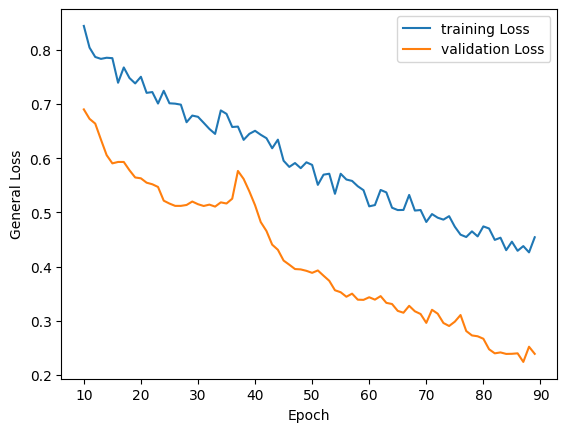

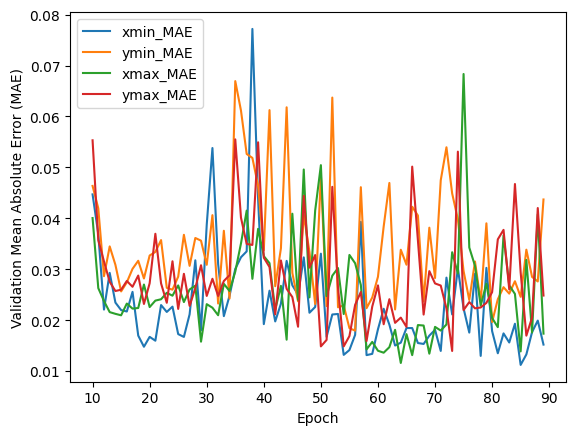

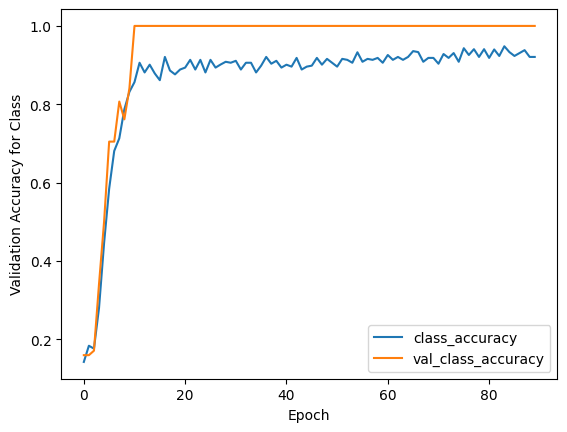

In [ ]:
# Visualize the results after training
flag = 10

def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist["epoch"] = history.epoch

    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("General Loss")
    plt.plot(hist["epoch"][flag:], hist["loss"][flag:], label = "training Loss")
    plt.plot(hist["epoch"][flag:], hist["val_loss"][flag:], label = "validation Loss")
    plt.legend()

    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Validation Mean Absolute Error (MAE)")
    plt.plot(hist["epoch"][flag:], hist["val_xmin_mae"][flag:], label = "xmin_MAE")
    plt.plot(hist["epoch"][flag:], hist["val_ymin_mae"][flag:], label = "ymin_MAE")
    plt.plot(hist["epoch"][flag:], hist["val_xmax_mae"][flag:], label = "xmax_MAE")
    plt.plot(hist["epoch"][flag:], hist["val_ymax_mae"][flag:], label = "ymax_MAE")
    plt.legend()

    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Validation Accuracy for Class")
    plt.plot(hist["epoch"],hist["class_acc"], label = "class_accuracy")
    plt.plot(hist["epoch"],hist["val_class_acc"], label = "val_class_accuracy")
    plt.legend()

    plt.show()

plot_history(history)

In [ ]:
test_items = len(os.listdir(path_test))/2

results = model.evaluate(test_dataset, steps = test_items/batch_valid)

22/22 [==============================] - 2s 71ms/step - loss: 0.2384 - xmin_loss: 3.6586e-04 - ymin_loss: 0.0031 - xmax_loss: 4.2203e-04 - ymax_loss: 9.1583e-04 - class_loss: 0.2335 - xmin_mae: 0.0154 - xmin_acc: 0.0000e+00 - ymin_mae: 0.0463 - ymin_acc: 0.0111 - xmax_mae: 0.0159 - xmax_acc: 0.0000e+00 - ymax_mae: 0.0248 - ymax_acc: 0.0000e+00 - class_mae: 2.3889 - class_acc: 1.0000


In [ ]:
print("MAE of xmin value in test set:{}".format(results[6]))
print("MAE of ymin value in test set:{}".format(results[8]))
print("MAE of xmax value in test set:{}".format(results[10]))
print("MAE of ymax value in test set:{}".format(results[12]))
print("Testing accuracy of predicted label:{}".format(results[15]))

MAE of xmin value in test set:0.01544739119708538
MAE of ymin value in test set:0.04627246409654617
MAE of xmax value in test set:0.01594238542020321
MAE of ymax value in test set:0.024753926321864128
Testing accuracy of predicted label:1.0


1/1 [==============================] - 5s 5s/step


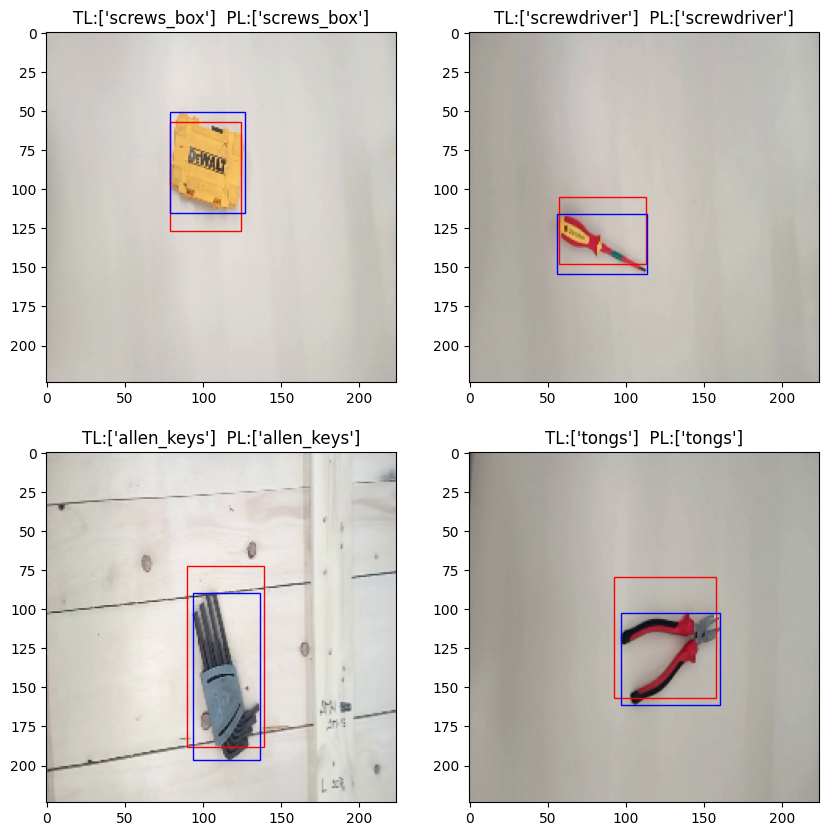

In [ ]:
# BLUE rectangle is ground truth
# RED rectangle is the prediction

plt.figure(figsize = (10,10))

for img, GT in test_dataset.take(1):
    out1, out2, out3, out4, out5 = model.predict(img)
    out1_gt, out2_gt, out3_gt, out4_gt, out5_gt = GT


    for i in range(4):

        plt.subplot(2, 2, i + 1)
        plt.imshow(keras.preprocessing.image.array_to_img(img[i]))

        plt.title('TL:{0}  PL:{1}'.format([clave for clave, valor in Class_dict.items() if valor == out5_gt[i]+1], [clave for clave, valor in Class_dict.items() if valor == np.argmax(out5[i])+1]))

        xmin, ymin, xmax, ymax = out1[i]*SIZE, out2[i]*SIZE, out3[i]*SIZE, out4[i]*SIZE
        rect = Rectangle((xmin,ymin), (xmax - xmin), (ymax - ymin), fill = False, color = "r")

        xmin, ymin, xmax, ymax = out1_gt[i]*SIZE, out2_gt[i]*SIZE, out3_gt[i]*SIZE, out4_gt[i]*SIZE
        rect2 = Rectangle((xmin,ymin), (xmax - xmin), (ymax - ymin), fill = False, color = "b")

        ax = plt.gca()
        ax.axes.add_patch(rect)
        ax.axes.add_patch(rect2)

## LOCALIZATION IS GOOD

### Conclusión final:

Finalmente, podemos este último codigo destaca por tener las mejores predicciones y el menor "mae" en cada uno de los outputs.

Esto se puede deber a las siguientes causas:

1.- Eficiencia en la predicción: Durante el entrenamiento, el modelo muestra una buena capacidad para predecir las coordenadas de las bounding boxes y las clasificaciones con resultados satisfactorios tanto en el conjunto de entrenamiento como en el de validación. Esto indica que el modelo ha aprendido bien los patrones de las imágenes.

2.- Buen rendimiento en métricas clave: Al observar las métricas de pérdida y precisión, se puede notar que ha logrado una baja pérdida y una alta precisión en la clasificación, lo que sugiere que el modelo está capturando eficazmente la información relevante de las imágenes.

3.- Complejidad adecuada: A pesar de tener múltiples salidas para las coordenadas de las bounding boxes y la clasificación, el modelo parece ser lo suficientemente complejo como para capturar la diversidad de patrones en los datos, pero no demasiado complejo como para caer en sobreajuste.

Cabe destacar que el modelo seguía mejorando constantemente. Podemos observar en los gráficos anteriores una tendencia decreciente, pero no convergente, lo que sugiere que el modelo todavía estaba en proceso de mejora. Por lo tanto, es importante tener en cuenta que al proporcionar más épocas de entrenamiento, este modelo podría ser capaz de ofrecer predicciones aún mejores.

En el notebook de comparación, podremos visualizar cómo este modelo se compara con otros modelos como ViT, EfficientNetB6, EfficientNetB7 y otros mencionados. Esto nos permitirá tener una visión más completa y clara sobre qué modelo se destaca en términos de rendimiento, generalización y capacidad predictiva para cada uno de los outputs.
